## Model: mt5
attention based model

"Rick is cool, I like the way he looks." -> MODEL -> sijfiosdjfiosj

In [9]:
!pip install transformers sentencepiece datasets
!pip install GPUtil
!pip install torch
!pip install protobuf

     |████████████████████████████████| 1.1 MB 14.9 MB/s eta 0:00:0101


In [10]:
 from datasets import load_dataset
#from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
sns.set()

In [4]:
#free_gpu_cache()

NameError: name 'free_gpu_cache' is not defined

In [11]:
#
model_repo = 'google/mt5-base'
max_seq_len = 20

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [36]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
#model = model.cuda()

In [37]:
gpu_usage()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 | 18% | 94% |


In [38]:
input_sent = 'Here is our test sentence!'
token_ids = tokenizer.encode(input_sent, return_tensors='pt')
token_ids

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[     0, 250099,    260,      1]])
<pad> <extra_id_0>.</s>


In [39]:
#pass
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

ModuleNotFoundError: No module named 'pynvml'

In [11]:
#pass
free_gpu_cache()

NameError: name 'free_gpu_cache' is not defined

# Steps
1. Load the pretrained model and tokenizer
2. Load in the dataset
3. Transform the dataset into input
4. Train/finetune the model on our dataset
5. Test the model

In [40]:
example_input_str = '<jp>This is a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[250101,   1494,    339,    259,    262,   2978,    259,    272,   1982,
           1315,    260,      1]])
Tokens: ['<jp>', '▁This', '▁is', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [13]:
# sorted(tokenizer.vocab.items(), key=lambda x: x[1])

In [41]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

No config specified, defaulting to: alt/alt-parallel
Reusing dataset alt (/tmp/xdgcache-yzhang18/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed)


  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [43]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [44]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [45]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 768)

In [46]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[250101,   1494,    339,    259,    262,   2978,    259,    272,   1982,
           1315,    260,      1,      0,      0,      0,      0,      0,      0,
              0,      0]])


In [48]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs)
  batch_target_ids = torch.cat(targets)

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=8):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [49]:
in_ids, out_ids = format_translation_data(
    train_dataset[1]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<en> ▁ アンド レア ・ マー ジ が 開始 4 分 後の トライ で イタリア にとって 最初の 得点 を入れ た 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Andrea ▁Masi ▁ opened ▁the ▁scor ing ▁in ▁the ▁four th ▁minute ▁with ▁ a ▁try ▁for ▁Italy . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [22]:
#pass
torch.cuda.empty_cache()
gc.collect()

NameError: name 'torch' is not defined

### **Train/Finetune BERT**

In [50]:
n_epochs = 5
batch_size = 1
print_freq = 50
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [51]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/home/yzhang18/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
losses = []

In [53]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [54]:
test_loss = eval_model(model, test_dataset)
#losses = []

In [55]:
test_loss

22.0258686542511

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  try:
    data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                        tokenizer, batch_size)
  except RuntimeError:
    print("out of memory")
    
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()
      
    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

/tmp/ipykernel_23781/874628701.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/18094 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 16.448 | lr: 2.765486725663717e-05
Epoch: 1 | Step: 100 | Avg. loss: 13.323 | lr: 5.530973451327434e-05
Epoch: 1 | Step: 150 | Avg. loss: 10.630 | lr: 8.296460176991152e-05
Epoch: 1 | Step: 200 | Avg. loss: 9.241 | lr: 0.00011061946902654868
Epoch: 1 | Step: 250 | Avg. loss: 7.421 | lr: 0.00013827433628318584
Epoch: 1 | Step: 300 | Avg. loss: 6.691 | lr: 0.00016592920353982303
Epoch: 1 | Step: 350 | Avg. loss: 5.787 | lr: 0.00019358407079646017
Epoch: 1 | Step: 400 | Avg. loss: 5.719 | lr: 0.00022123893805309737
Epoch: 1 | Step: 450 | Avg. loss: 5.108 | lr: 0.0002488938053097345
Epoch: 1 | Step: 500 | Avg. loss: 5.171 | lr: 0.0002765486725663717
Epoch: 1 | Step: 550 | Avg. loss: 4.903 | lr: 0.00030420353982300885
Epoch: 1 | Step: 600 | Avg. loss: 4.484 | lr: 0.00033185840707964607


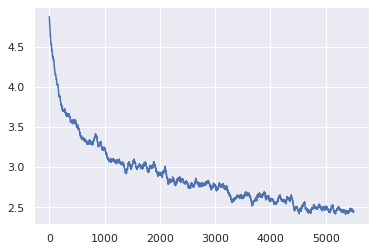

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

### **Manual Testing**

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

それは、Randwickのレースコースで8人以上のサーブ・レースのサーブ
それは、Randwickのレースコースで8人以上のサーブ・レースの乗組
それは、Randwickのレースコースで8人以上のサーブの乗組員が


In [ ]:
#@title Slick Blue Translate
input_text = '' #@param {type:"string"}
output_language = 'zh' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

qin  ->  洪都拉斯和格鲁吉亚和格鲁吉亚和格鲁吉亚
